<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/04_Transfer_learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 - Transer learning in tensorflow part 1 Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all them to be learning, however, there is still plenty of room for improvement.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned  from datasets such as [`ImageNet`](https://image-net.org/) (millions of images different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

## What we're going to cover

We're going to go through the following with TensorFlow:
- Introduce transfer learning 
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transer learning feature extraction model using Tensorflow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

## Using a GPU

To begin, let's check to see if we're using a GPU. Using a GPU will make sure our model trains faster than using just a CPU.


In [1]:
!nvidia-smi

Sat Aug 20 14:19:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [4]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-20 14:23:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 142.250.1.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   268MB/s    in 0.6s    

2022-08-20 14:23:42 (268 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [11]:
# How many images in each Folder? Inspect our data
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories ({dirnames}), {len(filenames)} images in '{dirpath}'")

There are 2 directories (['test', 'train']), 0 images in '10_food_classes_10_percent'
There are 10 directories (['steak', 'grilled_salmon', 'fried_rice', 'chicken_wings', 'sushi', 'hamburger', 'chicken_curry', 'pizza', 'ramen', 'ice_cream']), 0 images in '10_food_classes_10_percent/test'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories ([]), 250 images in '10_food_classes_10_percent/test/pizza'
There

In [26]:
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def visualize_image(targer_dir,target_class):
  """
  Visualize a random picture of a selected class from a target directory 
  
  Inputs:
  - target_dir : path of the target directory
  - target_class : name of the target class

  Return:
  - img : image
  """
  
  # target folder
  target_folder = f"{targer_dir}/{target_class}"

  for i in range(5):
    # take a random image inside the folder
    random_image = random.sample(os.listdir(target_folder),1)

    # plot the image
    img = mpimg.imread(f"{target_folder}/{random_image[0]}")
    print(f"Shape of the image: {img.shape}")
    plt.figure()
    plt.imshow(img)
    plt.show()

Shape of the image: (512, 512, 3)


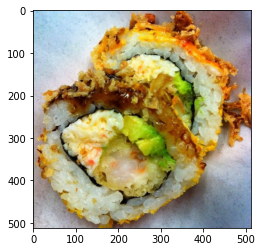

Shape of the image: (384, 512, 3)


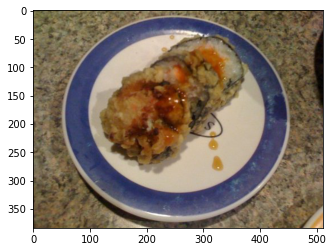

Shape of the image: (382, 512, 3)


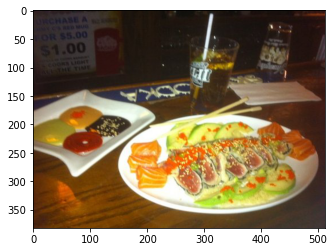

Shape of the image: (512, 384, 3)


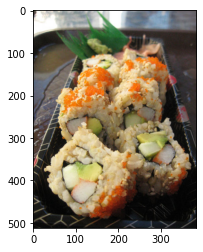

Shape of the image: (384, 512, 3)


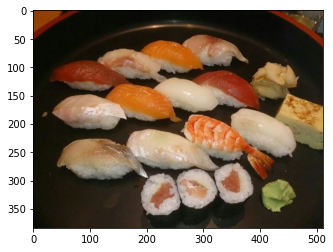

In [27]:
# Visualize random images
visualize_image("10_food_classes_10_percent/train","sushi")

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

## Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the `ImageDataGenerator` class along with the `flow_from_directory` method to load in our images.

In [28]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class)

## Setting up callbacks (things to run whilts our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[`Callbacks`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

- **[`Experiment tracking with TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)** - log the performance of multiple models and then view and compare these models in a visual war on **TensorBoard** (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on our data.
- **[`Model checkpointing`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)** - save your moel as it trains so you can stop training if needed and come back to continue off where you left. Helpful it training takes a long time and can't be done in one sitting.
- **[`Early stopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)** - leave your model training for an arbitrary amount of time and have it stop straining automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using `tf.keras.callbacks.TensorBoard()`.

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq=epoch` parameter. This is a good default since tracking model performance too often can slow down model training. 

To track our modelling experiments using TensorBoard, let's create a function wich creates a TensorBoard callback for us.

> **Note :** We create a function for creating a TensorBoard callback because as we'll see leter on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [35]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  # path of the directory where to save the log files to be parsed by TensorBoard
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
  
  # tensorboard callback
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

  print(f"Saving TensorBoard log files to : {log_dir}")

  return tensorboard_callback

Because we're lickely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our functions saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:

- `dir_name` is the overall logs directory
- `experiment_name` is the particular experiment
- `current_timestamp` is the time the experiment started based on Python's `datetime.datetime().now()`.